In [17]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from utils.matplotlib_functions import single_ax_plot
from utils.sklearn_functions import cross_validation

# Cleaning the raw data

In [18]:
raw = pd.read_csv('../data_gathering/wind/wf1.csv', index_col=0, parse_dates=True)

new_index = []
for stamp in raw.index:
    new = '2' + stamp[1:]
    new_index.append(new)

raw.index = pd.to_datetime(new_index)

In [19]:
from utils.pd_functions import check_duplicate_index, check_duplicate_rows, check_nans, check_index_length

In [20]:
check_duplicate_index(raw)

no duplicates found


In [21]:
check_duplicate_rows(raw)

no duplicate rows found


In [22]:
check_nans(raw)

0 nans


In [23]:
_ = check_index_length(raw, freq='1H')

ideal index len 17518
actual index len 16920
missing are:
{Timestamp('2000-02-28 14:00:00', freq='H'), Timestamp('2001-12-02 11:00:00', freq='H'), Timestamp('2001-12-03 19:00:00', freq='H'), Timestamp('2000-01-23 13:00:00', freq='H'), Timestamp('2001-12-05 14:00:00', freq='H'), Timestamp('2001-12-04 17:00:00', freq='H'), Timestamp('2001-12-04 19:00:00', freq='H'), Timestamp('2000-10-27 05:00:00', freq='H'), Timestamp('2000-02-29 10:00:00', freq='H'), Timestamp('2000-02-27 18:00:00', freq='H'), Timestamp('2001-12-05 18:00:00', freq='H'), Timestamp('2000-03-31 14:00:00', freq='H'), Timestamp('2000-02-27 19:00:00', freq='H'), Timestamp('2001-12-04 18:00:00', freq='H'), Timestamp('2000-01-22 16:00:00', freq='H'), Timestamp('2000-01-23 06:00:00', freq='H'), Timestamp('2001-09-05 09:00:00', freq='H'), Timestamp('2000-02-29 01:00:00', freq='H'), Timestamp('2000-03-01 10:00:00', freq='H'), Timestamp('2001-03-30 07:00:00', freq='H'), Timestamp('2000-01-24 12:00:00', freq='H'), Timestamp('2000-1

In [24]:
raw.head()

,ForecastingTime,AirPressure,Temperature,Humidity,WindSpeed100m,WindSpeed10m,WindDirectionZonal,WindDirectionMeridional,PowerGeneration
2000-01-01 01:00:00,25,0.392238,0.406113,0.638134,0.625094,0.548931,0.820776,0.883540,0.506970
2000-01-01 02:00:00,26,0.379920,0.405190,0.614377,0.628325,0.563099,0.812227,0.890531,0.579394
2000-01-01 03:00:00,27,0.367603,0.404268,0.590621,0.631556,0.577266,0.803525,0.897331,0.524848
2000-01-01 04:00:00,28,0.360061,0.401325,0.598596,0.629573,0.582233,0.791599,0.906165,0.543939
2000-01-01 05:00:00,29,0.352519,0.398381,0.606571,0.627590,0.587199,0.779416,0.914640,0.620606


# Feature engineering

In [25]:
from sklearn.pipeline import make_pipeline, make_union

from sklearn.preprocessing import StandardScaler

import utils.pipelines as p


def make_feature_pipeline(LAGS, HORIZIONS):

    lag_target = make_pipeline(
        p.ColumnSelector(['PowerGeneration']),
        p.OffsetGenerator('lag', LAGS),
        p.AlignPandas(LAGS, HORIZIONS),
        p.AsMatrix()
    )
    
    lag_features = make_pipeline(
        p.ColumnDropper(['PowerGeneration', 'ForecastingTime']),
        p.OffsetGenerator('lag', [LAGS[0]]),
        p.AlignPandas(LAGS, HORIZIONS),
        p.AsMatrix()
    )
    
    #  might be wrong!!!!! becuase data is hourly!!!
    cyclical_h = make_pipeline(
        p.HourlyCyclicalFeatures(),
        p.AlignPandas(LAGS, HORIZIONS),
        p.AsMatrix()
    )
    
    fc_time_cyclical = make_pipeline(
        p.ColumnSelector(['ForecastingTime']),
        p.CyclicalFeatures(raw.loc[:, 'ForecastingTime'].max()),
        p.AlignPandas(LAGS, HORIZIONS),
        p.AsMatrix(),
    )
    
    return make_union(lag_target, lag_features, cyclical_h, fc_time_cyclical)

def make_feature_cols(LAGS, HORIZIONS):
    lag_target_cols = ['PowerGeneration lag_{}'.format(l) for l in LAGS]
    lag_feature_cols = p.ColumnDropper(['PowerGeneration', 'ForecastingTime']).transform(raw).columns.tolist()
    lag_feature_cols = ['{} lag_{}'.format(col, 0) for col in lag_feature_cols]
    cyclical_h_cols = ['H_sin', 'H_cos']
    cyclical_fctime_cols = ['ForecastingTime sin', 'ForecastingTime cos']
    cols = lag_target_cols
    cols.extend(lag_feature_cols)
    cols.extend(cyclical_h_cols)
    cols.extend(cyclical_fctime_cols)
    
    return cols
    
def make_target_pipeline(LAGS, HORIZIONS):
    return make_pipeline(p.ColumnSelector('PowerGeneration'),
                         p.OffsetGenerator('horizion', HORIZIONS),
                         p.AlignPandas(LAGS, HORIZIONS),
                         p.AsMatrix())

In [26]:
LAGS = [0, 1, 2, 3, 4]
HORIZIONS = [1]

feature_pipe = make_feature_pipeline(LAGS, HORIZIONS)
feature_cols = make_feature_cols(LAGS, HORIZIONS)

target_pipe = make_target_pipeline(LAGS, HORIZIONS)

In [27]:
split = int(0.3 * raw.shape[0])
holdout = raw.iloc[-split:, :]
data = raw.iloc[:-split, :]

assert holdout.shape[0] + data.shape[0] == raw.shape[0]

features = feature_pipe.fit_transform(data)

assert features.shape[1] == len(feature_cols)

target = target_pipe.fit_transform(data)

print('features shape {} target shape {}'.format(features.shape, target.shape))

features shape (11839, 16) target shape (11839, 1)


In [28]:
def plot_feature_importances(rf, cols):
    importances = pd.DataFrame()
    importances.loc[:, 'importances'] = rf.feature_importances_
    importances.loc[:, 'features'] = cols
    importances.sort_values('importances', inplace=True)
    return single_ax_plot(importances, 'features', 'importances', kind='barh', color='b')

In [29]:
out = cross_validation(
    RandomForestRegressor, 
    {'n_estimators': 2000, 'max_features': 0.5, 'n_jobs': -1},
    make_feature_pipeline,
    make_target_pipeline,
    {'LAGS':LAGS, 'HORIZIONS': HORIZIONS},
    raw,
    n_folds=3,
    verbose=True)

running 3 folds cross_validation over {'max_features': 0.5, 'n_jobs': -1, 'n_estimators': 2000}
fold 1 98.9 % train score 91.4 % test score
fold 2 98.9 % train score 89.1 % test score
fold 3 98.8 % train score 92.2 % test score


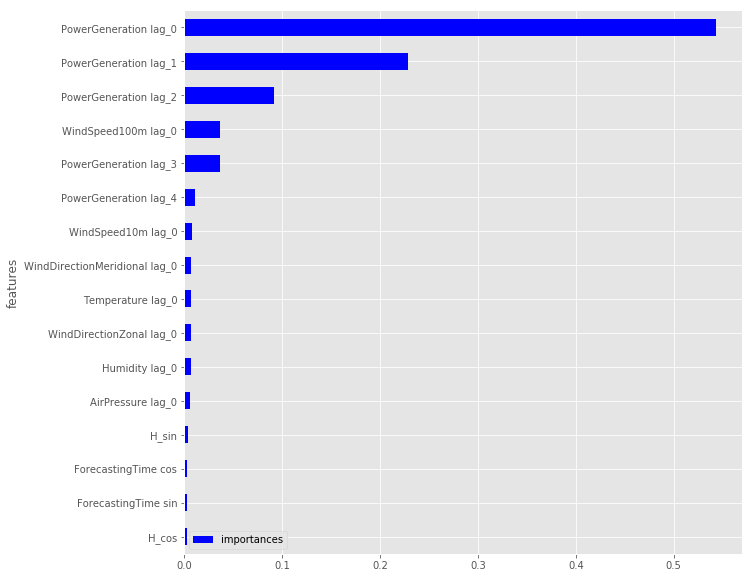

In [30]:
model = out['models'][-1]
_ = plot_feature_importances(model, feature_cols)

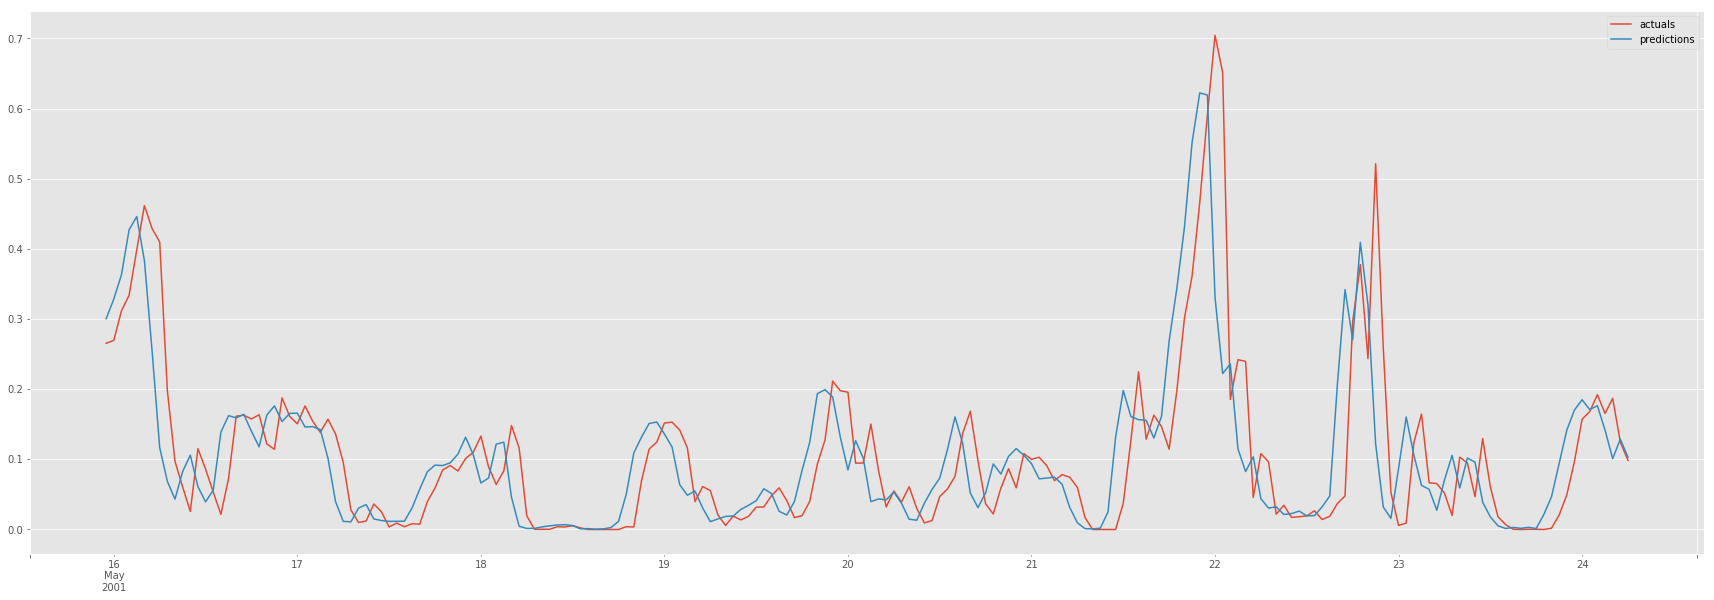

In [31]:


def plot_predictions(model, features, original_data):
    
    preds = pd.DataFrame()
    
    preds.loc[:, 'predictions'] = model.predict(features)
    
    subset = original_data.iloc[max(LAGS):-max(HORIZIONS), :]
    
    actuals = subset.loc[:, 'PowerGeneration'].shift(1)
    
    preds.index = actuals.index
    preds.loc[:, 'actuals'] = actuals
    
    f, a = plt.subplots(figsize=(30, 10))

    preds = preds.iloc[-200:, :]

    preds.plot(ax=a, y='actuals')
    preds.plot(ax=a, y='predictions')
    
    return f
    
_ = plot_predictions(model, features, data)

In [32]:
feature_pipe = out['feature_pipe'][-1]
target_pipe = out['target_pipe'][-1]

holdout_features = feature_pipe.transform(holdout)
holdout_target = target_pipe.transform(holdout)
holdout_score = model.score(holdout_features, holdout_target)

print('hold out test score is {:2.2f} %'.format(100*holdout_score))

hold out test score is 92.63 %
